In [1]:
import numpy as np
from qiskit import IBMQ, assemble
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.jobstatus import JobStatus

In [2]:
import matplotlib.pyplot as plt
from qiskit import IBMQ, assemble
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.providers.jobstatus import JobStatus
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit.circuit.library import XXPlusYYGate

In [3]:
### parameterisation
from scipy.constants import h 
hbar = h/2*np.pi
U = 2
J = 1
dtau = -0.3*hbar/J

K_angle = dtau*J/hbar
c_phase_angle = -dtau*U/hbar

In [4]:
n = 16
circuit = QuantumCircuit(n,n)

In [5]:
# Set-up SqrtISWAP gate
sqrt2 = np.sqrt(2)
SqrtISWAP = Operator( [
    [1, 0, 0, 0],
    [0, 1/sqrt2, 1j/sqrt2, 0],
    [0, 1j/sqrt2, 1/sqrt2, 0],
    [0, 0, 0, 1] ])

# Create a Quantum Circuit acting on the q register 
n = 16
circuit = QuantumCircuit(n,n)

g_angles_up = [-1.530, -1.552, -1.541, -1.497, -1.214, -1.285, -0.311, -0.6168, -0.3738, -0.2199, -0.4508, -0.1271]
g_angles_down = [-1.370, -1.282, -1.213, -1.040, -1.087, -0.8378, -0.9723, -0.6613, -0.8592, -0.4833, -0.7414, -0.2856]

### Define function to add Givens rotaion to circuit
def addGivens(a, b, theta):
    circuit.unitary(SqrtISWAP, [a,b])
    circuit.rz(-theta, a)
    circuit.rz(theta, b)
    circuit.unitary(SqrtISWAP.transpose().conjugate(), [a,b])
        
def initialise(n0,q):
    circuit.x(n0)
    circuit.x(n0+1)
    addGivens(n0 + 1, n0 + 2, -1.53)
    addGivens(n0, n0 + 1, -1.552)
    addGivens(n0 + 2, n0 + 3, -1.541)
    addGivens(n0 + 1, n0 + 2, -1.497)
    addGivens(n0 + 3, n0 + 4, -1.214)
    addGivens(n0 + 2, n0 + 3, -1.285)
    addGivens(n0 + 4, n0 + 5, -0.311)
    addGivens(n0 + 3, n0 + 4, -0.6168)
    addGivens(n0 + 5, n0 + 6, -0.3738)
    addGivens(n0 + 4, n0 + 5, -0.2199)
    addGivens(n0 + 6, n0 + 7, -0.4508)
    addGivens(n0 + 5, n0 + 6, -0.1271)
    
def initialise1(n0,q):
    circuit.x(n0)
    circuit.x(n0+1)
    addGivens(n0 + 1, n0 + 2, -1.37)
    addGivens(n0, n0 +1, -1.282)
    addGivens(n0 + 2,n0+3,-1.213)
    addGivens(n0 + 1, n0 + 2, -1.040)
    addGivens(n0 + 3, n0 + 4, -1.087)
    addGivens(n0 + 2, n0 + 3, -0.8378)
    addGivens(n0 + 4, n0 + 5, -0.9723)
    addGivens(n0 + 3, n0 + 4, -0.6613)
    addGivens(n0 + 5, n0 + 6, -0.8592)
    addGivens(n0 + 4, n0 + 5, -0.4833)
    addGivens(n0 + 6, n0 + 7, -0.7414)
    addGivens(n0 + 5, n0 + 6, -0.2856)

initialise(0, 8)
initialise1(8, 8)


#circuit.draw('mpl')

In [6]:
def trotterstep():
    sqrt2 = np.sqrt(2)
    SqrtISWAP = Operator( [
        [1, 0, 0, 0],
        [0, 1/sqrt2, 1j/sqrt2, 0],
        [0, 1j/sqrt2, 1/sqrt2, 0],
        [0, 0, 0, 1] ])
    def addKGate(a,b,theta): 
        XXYYGate = XXPlusYYGate(2*theta,0) 
        circuit.append(XXYYGate, [a,b])
    def addCPHASE(a,b,theta): 
        circuit.cp(-theta,a,b)
        
    def addiSwap(a,b): 
        circuit.iswap(a,b) 
    
    # J odd 
    i=0 
    while i<n-1: 
        addKGate(i, i+1, K_angle) 
        i+=2 
        
    # U odd 
    i=0 
    while i<7: 
        addCPHASE(i, int(i + n/2),c_phase_angle)
        i+=2 
        
    # iSwap 
    i=1 
    while i<7: 
        addiSwap(i, i+1)
        i+=2 
    i=9 
    while i<14: 
        addiSwap(i, i+1) 
        i+=2 
    #U even
    i=2 
    while i<7: 
        addCPHASE(i, int(i + n/2), c_phase_angle) 
        i+=2 
    addCPHASE(7, 15, c_phase_angle) 
    # J even iSwap adjoint 
    i=1 
    while i<7: 
        addKGate(i, i+1,K_angle + (np.pi/2)) 
        i+=2 
    
    i=9 
    while i<14: 
        addKGate(i, i+1,K_angle + (np.pi/2)) 
        i+=2

trotterstep()
#print(K_angle)
#print(c_phase_angle)
#circuit.draw('mpl')

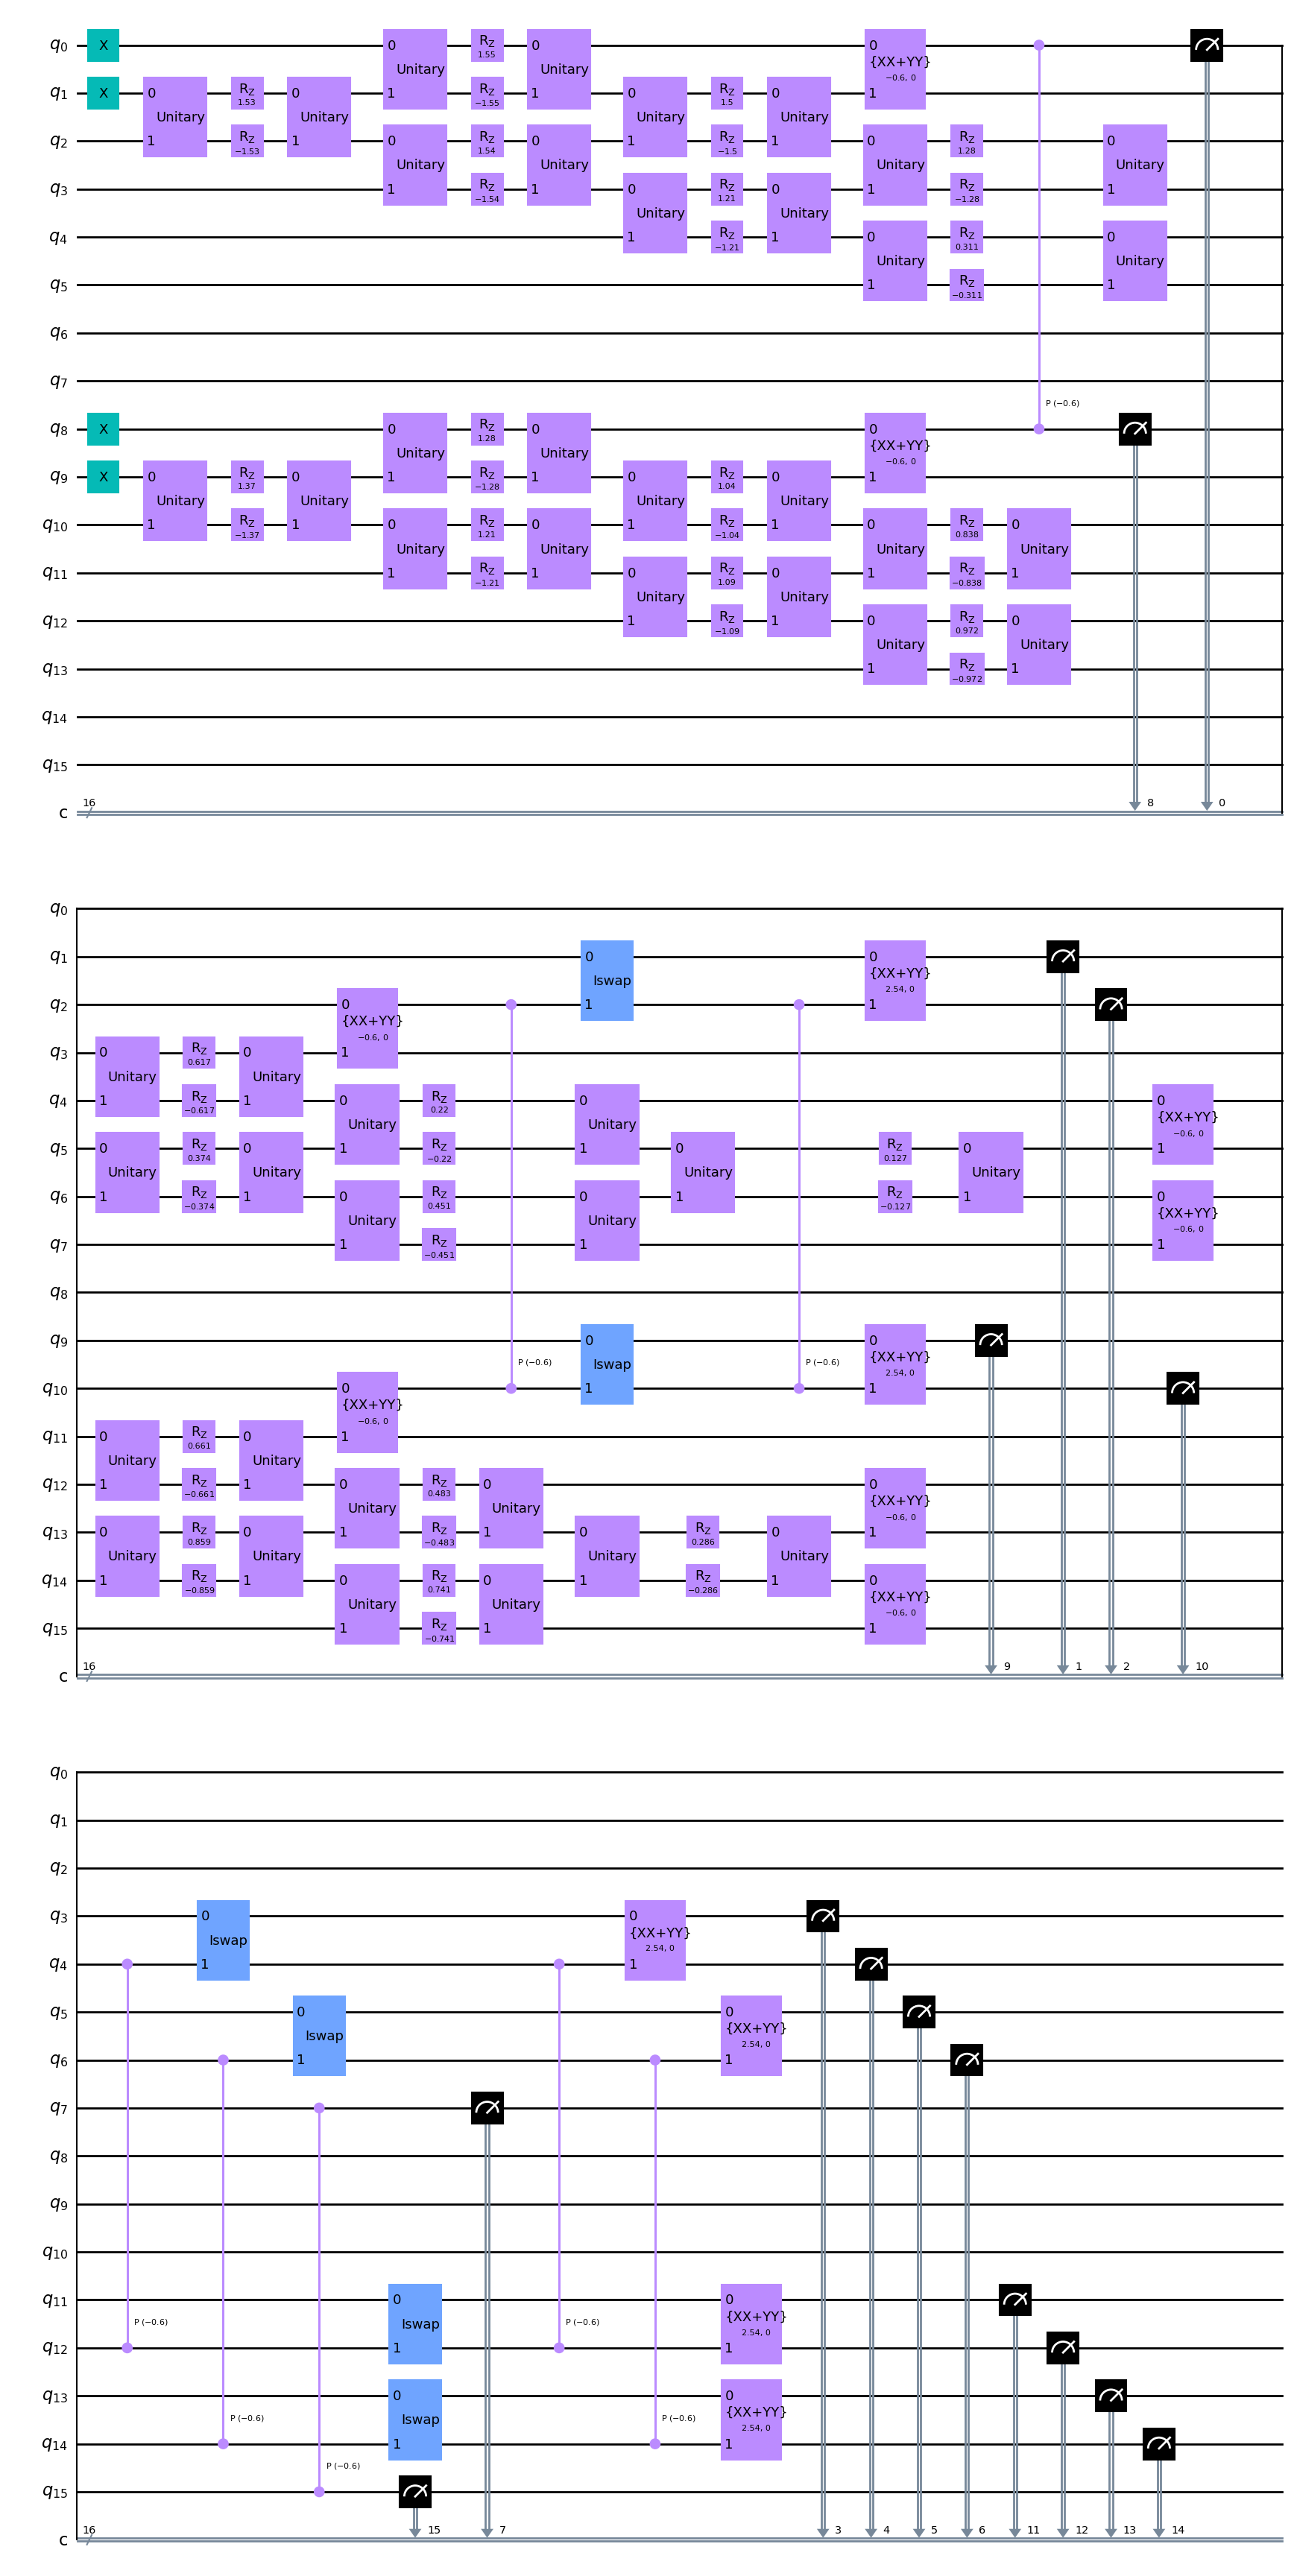

In [7]:
def takeMeasure(nmax):
    arr = list(range(0,nmax))
    circuit.measure(arr,arr)
    
takeMeasure(16)
circuit.draw('mpl')

In [8]:
allupdensity = np.zeros([11,8])
alldowndensity = np.zeros([11,8])

In [9]:
provider = IBMQ.save_account("ed5fdb9745e00ef1a0e87bfc75a7c1ffc61545cd826a2a530c01e1f5252c2057feb2f0cabdd18e23b9a28de8a8ea7d3d6de674246d8e78922dd7c855a1684d51")

provider = IBMQ.load_account()

backend = provider.backend.ibmq_belem

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

C:\Users\james\AppData\Local\Temp\ipykernel_25448\219164754.py:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.save_account("ed5fdb9745e00ef1a0e87bfc75a7c1ffc61545cd826a2a530c01e1f5252c2057feb2f0cabdd18e23b9a28de8a8ea7d3d6de674246d8e78922dd7c855a1684d51")
C:\Users\james\AppData\Local\Temp\ipykernel_25448\219164754.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.I

In [10]:
newresults = job.result().data()
#print(newresults)
allupdensity = np.zeros([11,8])
alldowndensity = np.zeros([11,8])

[0.13675 0.328   0.53075 0.99475 0.9895  0.5415  0.33925 0.1395 ]
[-0.13175 -0.288   -0.07375  0.48375  0.484   -0.0565  -0.28925 -0.1285 ]


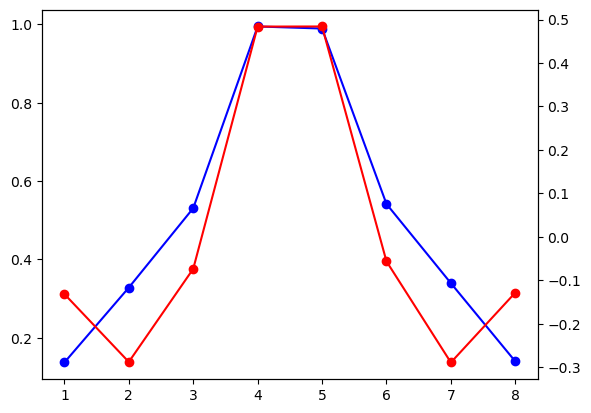

In [11]:
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)

updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[1] = upsitecount
alldowndensity[1] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

In [12]:
def initialise_circuit(circuit):
    occupied_orbitals = (0,1)
    up_circuit = SlaterDeterminant(up_transform[list])

[0.11725 0.31175 0.52375 1.057   1.0315  0.51225 0.31575 0.13075]
[-0.11375 -0.29775 -0.14775  0.552    0.555   -0.14775 -0.27425 -0.12575]


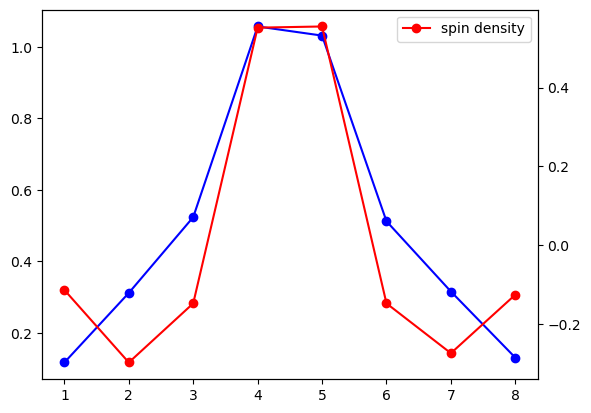

In [13]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 0

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

circuit.draw('mpl')
backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[0] = upsitecount
alldowndensity[0] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o', label = 'charge density')
ax2.plot(x, downdensity, color='r', marker = 'o', label = 'spin density')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.13025 0.33425 0.52275 1.011   0.983   0.53475 0.34375 0.14025]
[-0.12775 -0.30025 -0.07525  0.498    0.479   -0.04975 -0.29075 -0.13325]


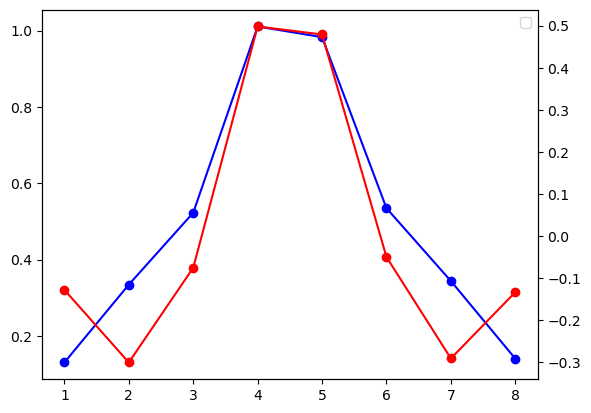

In [14]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 1

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

circuit.draw('mpl')
backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[0] = upsitecount
alldowndensity[0] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.legend()
plt.show()

[0.1515  0.43175 0.5935  0.81475 0.81    0.62675 0.414   0.15775]
[-0.1495  -0.26825  0.011    0.39975  0.396    0.01875 -0.2575  -0.15025]


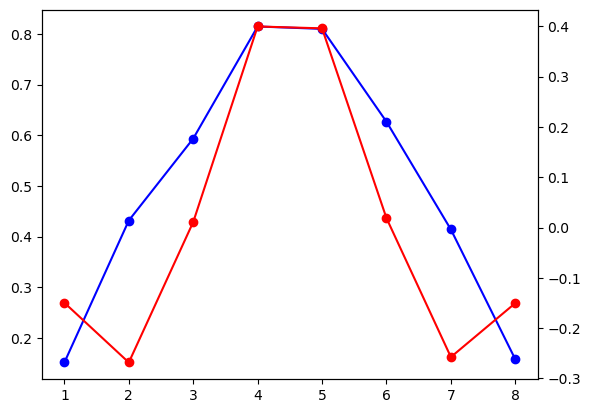

In [15]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 2

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

circuit.draw('mpl')
backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)

updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[2] = upsitecount
alldowndensity[2] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.17075 0.57975 0.605   0.62725 0.614   0.62625 0.58725 0.18975]
[-0.15825 -0.21875  0.102    0.26425  0.295    0.13325 -0.25525 -0.16225]


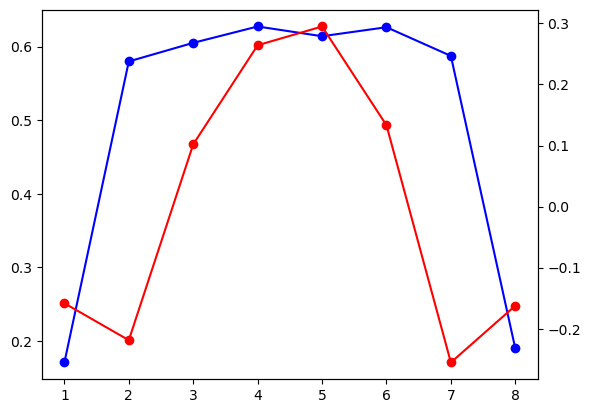

In [16]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 3

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[3] = upsitecount
alldowndensity[3] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.2425  0.752   0.5045  0.49925 0.48425 0.53125 0.7445  0.24175]
[-0.165   -0.172    0.156    0.17825  0.16025  0.18925 -0.183   -0.16375]


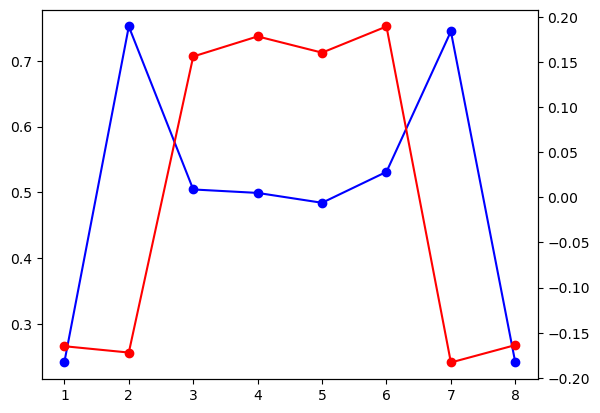

In [17]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 4

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[4] = upsitecount
alldowndensity[4] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.35975 0.77375 0.42425 0.441   0.42425 0.429   0.785   0.363  ]
[-0.14525 -0.09875  0.13975  0.1      0.08725  0.165   -0.0935  -0.1545 ]


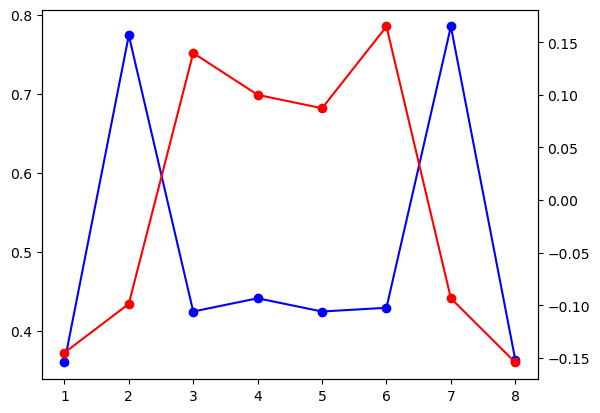

In [18]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 5

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[5] = upsitecount
alldowndensity[5] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.518   0.70275 0.39875 0.3755  0.36625 0.41175 0.6795  0.5475 ]
[-0.126   -0.03875  0.07475  0.068    0.07225  0.08625 -0.0145  -0.122  ]


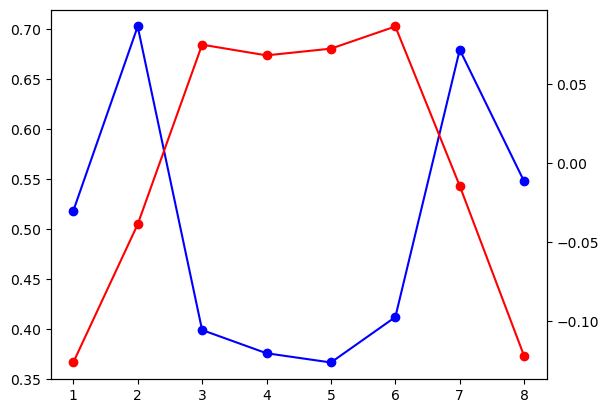

In [19]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 6

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)

updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[6] = upsitecount
alldowndensity[6] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.69675 0.57675 0.3945  0.34325 0.33775 0.37025 0.5545  0.72625]
[-0.08725 -0.00825 -0.0005   0.06525  0.10175 -0.03025  0.0375  -0.07825]


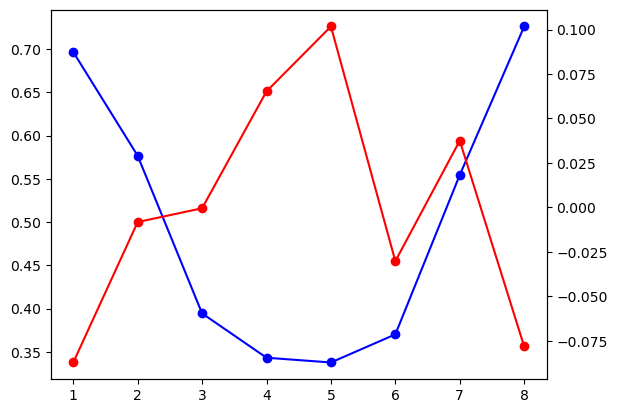

In [20]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 7

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)
maxshots = 8192

backend = provider.backend.ibmq_qasm_simulator
backend._configuration.max_shots= maxshots
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[7] = upsitecount
alldowndensity[7] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.8115  0.506   0.371   0.31025 0.319   0.38075 0.49225 0.80925]
[ 0.0145  -0.053   -0.0405   0.08075  0.0705  -0.08575  0.00475  0.00875]


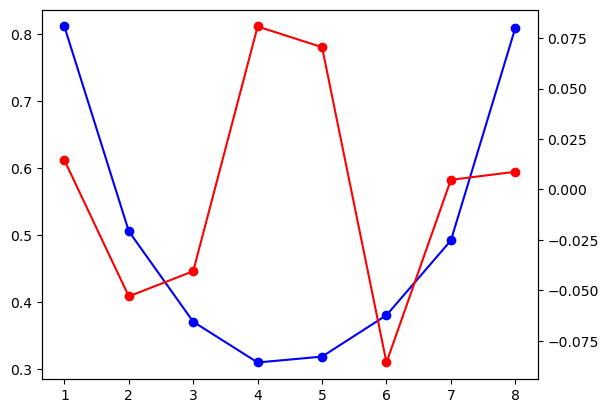

In [21]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 8

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[8] = upsitecount
alldowndensity[8] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.821   0.4785  0.396   0.315   0.295   0.40275 0.48825 0.8035 ]
[ 0.105   -0.1135  -0.0775   0.088    0.06    -0.11475 -0.06025  0.113  ]


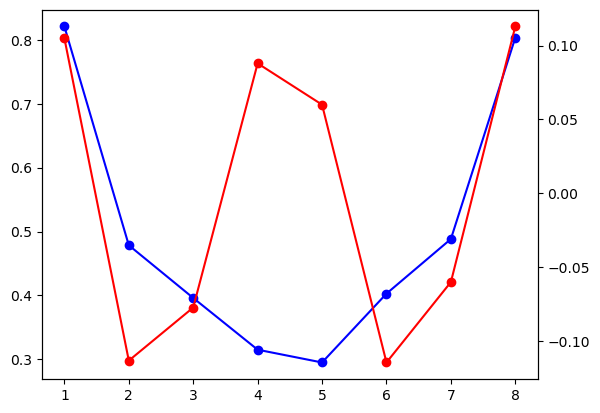

In [22]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 9

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)

updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[9] = upsitecount
alldowndensity[9] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.7185  0.55825 0.4215  0.298   0.3175  0.439   0.54275 0.7045 ]
[ 0.175   -0.16575 -0.091    0.0675   0.048   -0.0935  -0.14825  0.208  ]


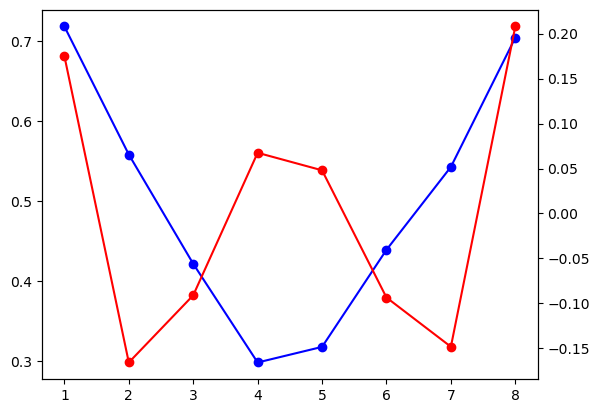

In [23]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 10

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)

updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[10] = upsitecount
alldowndensity[10] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[5.225   5.2355  5.8395  6.64675 7.4815  8.139   8.7715  9.29625 9.6105
 9.60575 9.3315 ]
[-2.09    -2.0655  -1.921   -1.67425 -1.351   -0.979   -0.6895  -0.46875
 -0.153    0.11425  0.3365 ]


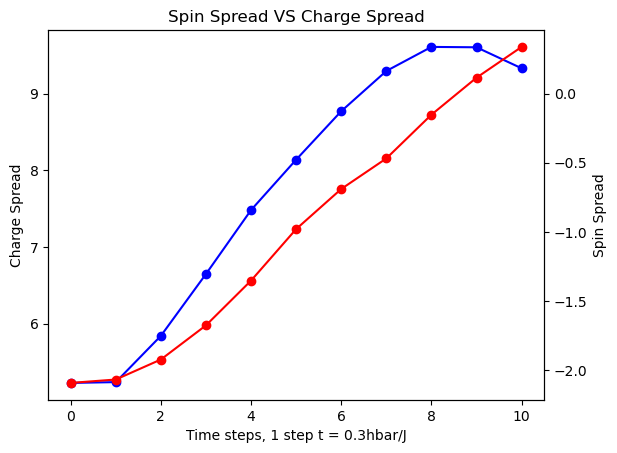

In [24]:
x = np.arange(1,3,0.3)

def kappavalues(a):
    mod1 = (np.sqrt(((1-(9/2))*a[0])**2))
    mod2 = (np.sqrt(((2-(9/2))*a[1])**2))
    mod3 = (np.sqrt(((3-(9/2))*a[2])**2))
    mod4 = (np.sqrt(((4-(9/2))*a[3])**2))
    mod5 = (np.sqrt(((5-(9/2))*a[4])**2))
    mod6 = (np.sqrt(((6-(9/2))*a[5])**2))
    mod7 = (np.sqrt(((7-(9/2))*a[6])**2))
    mod8 = (np.sqrt(((8-(9/2))*a[7])**2))
    arr = np.array([mod1,mod2,mod3,mod4,mod5,mod6,mod7,mod8])
    return np.sum(arr)

a1 = kappavalues(allupdensity[0])
a2 = kappavalues(allupdensity[1])
a3 = kappavalues(allupdensity[2])
a4 = kappavalues(allupdensity[3])
a5 = kappavalues(allupdensity[4])
a6 = kappavalues(allupdensity[5])
a7 = kappavalues(allupdensity[6])
a8 = kappavalues(allupdensity[7])
a9 = kappavalues(allupdensity[8])
a10 = kappavalues(allupdensity[9])
a11 = kappavalues(allupdensity[10])
plta = np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11])

b1 = kappavalues(alldowndensity[0])
b2 = kappavalues(alldowndensity[1])
b3 = kappavalues(alldowndensity[2])
b4 = kappavalues(alldowndensity[3])
b5 = kappavalues(alldowndensity[4])
b6 = kappavalues(alldowndensity[5])
b7 = kappavalues(alldowndensity[6])
b8 = kappavalues(alldowndensity[7])
b9 = kappavalues(alldowndensity[8])
b10 = kappavalues(alldowndensity[9])
b11 = kappavalues(alldowndensity[10])
pltb = np.array([b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11])

plta1 = plta + pltb
pltb1 = plta - pltb

print(plta1)
print(pltb1)

fig,ax = plt.subplots()
ax.plot(plta1,color = 'b', marker = 'o')
plt.ylabel('Charge Spread')
plt.xlabel('Time steps, 1 step t = 0.3hbar/J')
ax2 = ax.twinx()
ax2.plot(pltb1,color = 'r', marker = 'o')
plt.title('Spin Spread VS Charge Spread')
plt.ylabel('Spin Spread')
plt.show()
